# MVD 11. cvičení


## 1. část - Collaborative Filtering (item-item)

Vytvořte si matici podle příkladu v přednášce na item-item přístup na snímku 24. Využijte centered cosine similarity pro výpočet podobností stejně jako v přednášce a vyberte dva nejbližší sousedy. Ověřte, že je výsledek v přednášce správný a implementujte funkci tak, aby bylo možné jednoduše spočítat i libovolné další vyhodnocení. 

In [1]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
m = np.array([[1,0,3,0,0,5,0,0,5,0,4,0],
              [0,0,5,4,0,0,4,0,0,2,1,3],
              [2,4,0,1,2,0,3,0,4,3,5,0],
              [0,2,4,0,5,0,0,4,0,0,2,0],
              [0,0,4,3,4,2,0,0,0,0,2,5],
              [1,0,3,0,3,0,0,2,0,0,4,0]])

In [2]:
def coll_filter(M:np.array,item:tuple,k:int)-> float:
    normed = M - (np.sum(M,axis = 1) / np.count_nonzero(M, axis=1))[:,None]
    norm_M = np.where(M==0,0,normed) # where was zero, is zero in norm matrix
    sim = cosine_similarity([norm_M[item[0],:]],norm_M).squeeze()
    idx = np.flip(np.argsort(sim))[1:k+1] # find k nearest numbers (idx) | 1-k
    denum,num = 1e-8, 0
    for i in idx:
        denum += sim[i]
        num += (sim[i] * M[i,item[1]])

    return num/denum

In [3]:
out = coll_filter(M=m,item = (0,4),k = 2)
print(out)

2.586406841098622


## Bonus - Content-based Filtering

Stáhněte si Kaggle dataset [Spotify Recommendation system](https://www.kaggle.com/bricevergnou/spotify-recommendation). Z datasetu budete potřebovat:

- data.csv = příznaky k jednotlivým skladbám + příznak liked pro klasifikaci

Úkolem je:

1. Načíst data z csv.
2. Vytvořit train (90 %) a test (10 %) split pomocí knihovny [sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html).
3. Vytvořit model logistické regrese (vlastní implementace / využití knihovny sklearn nebo jiné).
4. Vyhodnotit data na testovací sadě (např. metoda score u LogisticRegression).

**Skóre pro uznání úlohy musí být vyšší než 89 %.**

Dobrovolné: vytvořit graf predikovaných vs aktuálních hodnot

Získání bodu navíc: Využijte i další algoritmy pro binární klasifikaci.

In [366]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [367]:
df = pd.read_csv('data.csv')
y = df["liked"]
x = df.loc[:, df.columns != 'liked']
train_x, test_x, train_y,test_y = train_test_split(x,y, test_size=0.1)

In [368]:
## Logistic Regression
model = LogisticRegression(solver='liblinear',C=10.0, random_state=0)
model.fit(train_x, train_y)
pred = model.predict(test_x)
p_pred = model.predict_proba(x)
actual = np.array(test_y.tolist())
score = model.score(test_x, test_y)
print(score)
#print(p_pred)

0.85


In [369]:
import sklearn

# transform from dataframe to tensor
x_train=train_x.to_numpy().astype(np.float32)
x_test=test_x.to_numpy().astype(np.float32)

## scaler
scaler=sklearn.preprocessing.StandardScaler()
x_train=torch.from_numpy(scaler.fit_transform(x_train))
x_test=torch.from_numpy(scaler.fit_transform(x_test))
## transform to torch
y_train=torch.from_numpy(train_y.to_numpy().astype(np.float32))
y_test=torch.from_numpy(test_y.to_numpy().astype(np.float32))
# transform from shape [20] to [20,1]
y_train=y_train.view(y_train.shape[0],1)
y_test=y_test.view(y_test.shape[0],1)



print(x_test.shape,y_test.shape,x_train.shape,y_train.shape)

torch.Size([20, 13]) torch.Size([20, 1]) torch.Size([175, 13]) torch.Size([175, 1])


In [370]:
from torch import nn

In [374]:
class LogReg(nn.Module):
  def __init__(self,input_shape):
    super(LogReg,self).__init__()
    #self.fc1 = nn.Linear(input_shape,20)
    self.fc2 = nn.Linear(input_shape,1)
  def forward(self, x):
    #y_pred = self.fc1(x)
    y_pred = torch.sigmoid(self.fc2(x))
    return y_pred



In [375]:
class MLP(nn.Module):
    def __init__(self,input_shape):
        super(MLP, self).__init__()
        self.layer_1 = nn.Linear(input_shape, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = torch.sigmoid(self.layer_out(x))

        return x


In [380]:
#hyper parameters
learning_rate = 1e-3
epochs = 100
iter_print = 5
criterion=torch.nn.BCELoss()

#model = LogReg(input_shape=x.shape[1]) # LR
model = MLP(input_shape=x.shape[1]) #MLP

optimizer=torch.optim.Adam(model.parameters(),lr=0.01)




In [381]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []
for epoch in range(epochs):
    y_prediction=model(x_train)
    loss=criterion(y_prediction,y_train)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    ## evaluate
    if (epoch+1)%iter_print == 0:
        train_loss.append(loss.detach().numpy())
        y_pred_class=y_prediction.round()
        accuracy_train=(y_pred_class.eq(y_train).sum())/float(y_train.shape[0])
        train_acc.append(accuracy_train.item())

        with torch.no_grad():
            model.eval()
            y_pred=model(x_test)
            loss=criterion(y_pred,y_test)
            test_loss.append(loss.detach().numpy())
            y_pred_class=y_pred.round()
            accuracy_test=(y_pred_class.eq(y_test).sum())/float(y_test.shape[0])
            test_acc.append(accuracy_test.item())
        print('epoch:', epoch+1,',loss=',loss.item(),'train acc=',accuracy_train,'test acc=',accuracy_test)
        model.train()


epoch: 5 ,loss= 0.4316810667514801 train acc= tensor(0.9429) test acc= tensor(0.8500)
epoch: 10 ,loss= 0.2639569342136383 train acc= tensor(0.9829) test acc= tensor(0.9000)
epoch: 15 ,loss= 0.2010534256696701 train acc= tensor(1.) test acc= tensor(0.9500)
epoch: 20 ,loss= 0.21328425407409668 train acc= tensor(1.) test acc= tensor(0.9500)
epoch: 25 ,loss= 0.2661387026309967 train acc= tensor(1.) test acc= tensor(0.9500)
epoch: 30 ,loss= 0.33150514960289 train acc= tensor(1.) test acc= tensor(0.9500)
epoch: 35 ,loss= 0.35603219270706177 train acc= tensor(1.) test acc= tensor(0.9500)
epoch: 40 ,loss= 0.39357268810272217 train acc= tensor(1.) test acc= tensor(0.9500)
epoch: 45 ,loss= 0.4283713698387146 train acc= tensor(1.) test acc= tensor(0.9500)
epoch: 50 ,loss= 0.44349122047424316 train acc= tensor(1.) test acc= tensor(0.9500)
epoch: 55 ,loss= 0.44517412781715393 train acc= tensor(1.) test acc= tensor(0.9500)
epoch: 60 ,loss= 0.4501970410346985 train acc= tensor(1.) test acc= tensor(0.

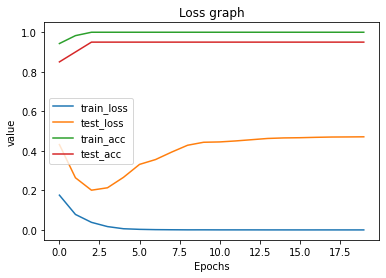

In [382]:
plt.plot(train_loss,label = "train_loss")
plt.plot(test_loss,label = "test_loss")
plt.plot(train_acc,label = "train_acc")
plt.plot(test_acc,label = "test_acc")
plt.title('Loss graph')
plt.xlabel('Epochs')
plt.ylabel('value')
plt.legend()
plt.show()